In [1]:
import numpy as np
import pandas as pd 
import os
import re
import pandas as pd
import numpy as np
import pickle as pkl
import os
from tabulate import tabulate
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import warnings
# Disable all warnings
warnings.filterwarnings("ignore")

from utils import *

In [2]:
path = "/home/ids/meladlouni/projects/nlp_project/data/train"
data_obs = extract_data(path, "OBS")
data_rct = extract_data(path, "RCT")


In OBS:
Only in x : 0 -> non-used
Only in y : 27 -> non-used
In both : 402

In RCT:
Only in x : 11 -> non-used
Only in y : 8 -> non-used
In both : 370


In [3]:
# Change the path to a writable directory
output_path = "/home/ids/meladlouni/projects/nlp_project/data/train_data.dat"

# Save the data
with open(output_path, "wb") as f:
    pkl.dump([data_obs, data_rct], f)

print(f"Data saved to {output_path}")


Data saved to /home/ids/meladlouni/projects/nlp_project/data/train_data.dat


In [4]:
print(f"OBS Dataset Shape: {data_obs.shape}")
print(f"RCT Dataset Shape: {data_rct.shape}")


OBS Dataset Shape: (402, 3)
RCT Dataset Shape: (370, 3)


In [5]:
# Preview the first few rows
print("OBS Dataset:")
print(data_obs.head())

print("\nRCT Dataset:")
print(data_rct.head())


OBS Dataset:
         id                                            article  \
0  34622531  1. INTRODUCTION \nGlobal concern for the COVID...   
1  37533930  1 Introduction\nThe outbreak of the novel SARS...   
2  34181466  INTRODUCTION \nRecurrent urinary tract infecti...   
3  34901993  Introduction\nMidlife hypertension is associat...   
4  28571704  Radiofrequency ablation (RFA) is an effective ...   

                                            abstract  
0  An in-depth characterization of the incidence,...  
1  INTRODUCTION: This study explored the differen...  
2  1/PURPOSE: The etiology of postmenopausal recu...  
3  OBJECTIVE: To investigate whether the associat...  
4  PURPOSE: The aim of this study was to assess t...  

RCT Dataset:
         id                                            article  \
0  36053287  An accessible, relational, inclusive, and acti...   
1  35701800  Antiprogestins reduce epigenetic field canceri...   
2  37759174  Introducing the participant-generat

In [6]:
print(f"Unique IDs in OBS: {data_obs['id'].nunique()} / {len(data_obs)}")
print(f"Unique IDs in RCT: {data_rct['id'].nunique()} / {len(data_rct)}")


Unique IDs in OBS: 402 / 402
Unique IDs in RCT: 370 / 370


In [7]:
data_obs.describe()

,id,article,abstract
count,402,402,402
unique,402,402,402
top,34622531,1. INTRODUCTION \nGlobal concern for the COVID...,"An in-depth characterization of the incidence,..."
freq,1,1,1


In [8]:
data_obs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 402 entries, 0 to 401
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        402 non-null    object
 1   article   402 non-null    object
 2   abstract  402 non-null    object
dtypes: object(3)
memory usage: 12.6+ KB


In [9]:
data_obs['article_length'] = data_obs['article'].apply(lambda x: len(x.split()))
data_obs['abstract_length'] = data_obs['abstract'].apply(lambda x: len(x.split()))

data_rct['article_length'] = data_rct['article'].apply(lambda x: len(x.split()))
data_rct['abstract_length'] = data_rct['abstract'].apply(lambda x: len(x.split()))

# Quick stats on lengths
print("OBS Article and Abstract Lengths:")
print(data_obs[['article_length', 'abstract_length']].describe())

print("\nRCT Article and Abstract Lengths:")
print(data_rct[['article_length', 'abstract_length']].describe())


OBS Article and Abstract Lengths:
       article_length  abstract_length
count      402.000000       402.000000
mean      4103.308458       279.873134
std       1621.507263        81.265436
min        819.000000        26.000000
25%       3041.250000       239.000000
50%       3779.000000       265.000000
75%       4854.750000       325.750000
max      11418.000000       755.000000

RCT Article and Abstract Lengths:
       article_length  abstract_length
count      370.000000       370.000000
mean      4004.586486       305.821622
std       1405.773820        85.189001
min       1032.000000        98.000000
25%       3069.000000       255.250000
50%       3746.000000       282.500000
75%       4629.000000       347.000000
max      10054.000000       624.000000


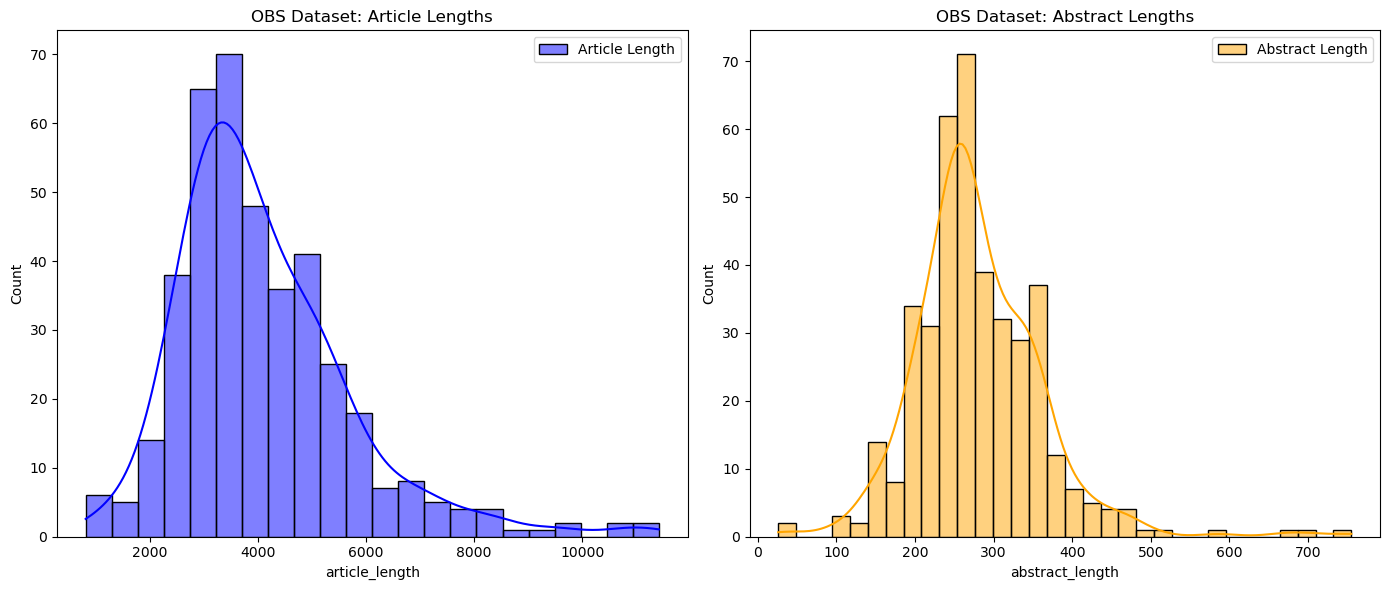

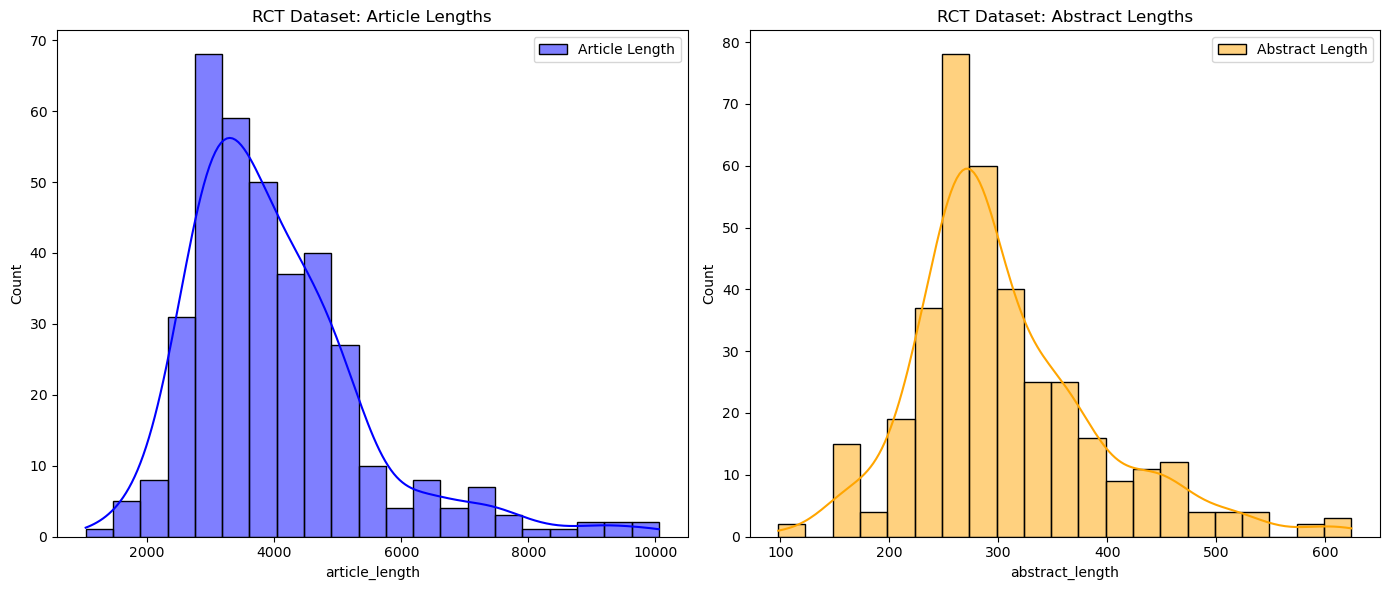

In [10]:
# For OBS articles and abstracts

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
# OBS: Article Lengths
sns.histplot(data_obs['article_length'], kde=True, color='blue', label='Article Length', ax=axes[0])
axes[0].legend()
axes[0].set_title("OBS Dataset: Article Lengths")
# OBS: Abstract Lengths
sns.histplot(data_obs['abstract_length'], kde=True, color='orange', label='Abstract Length', ax=axes[1])
axes[1].legend()
axes[1].set_title("OBS Dataset: Abstract Lengths")
# Adjust layout
plt.tight_layout()
plt.show()


################################################################################


# For RCT articles and abstracts

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
# RCT: Article Lengths
sns.histplot(data_rct['article_length'], kde=True, color='blue', label='Article Length', ax=axes[0])
axes[0].legend()
axes[0].set_title("RCT Dataset: Article Lengths")
# OBS: Abstract Lengths
sns.histplot(data_rct['abstract_length'], kde=True, color='orange', label='Abstract Length', ax=axes[1])
axes[1].legend()
axes[1].set_title("RCT Dataset: Abstract Lengths")
# Adjust layout
plt.tight_layout()
plt.show()


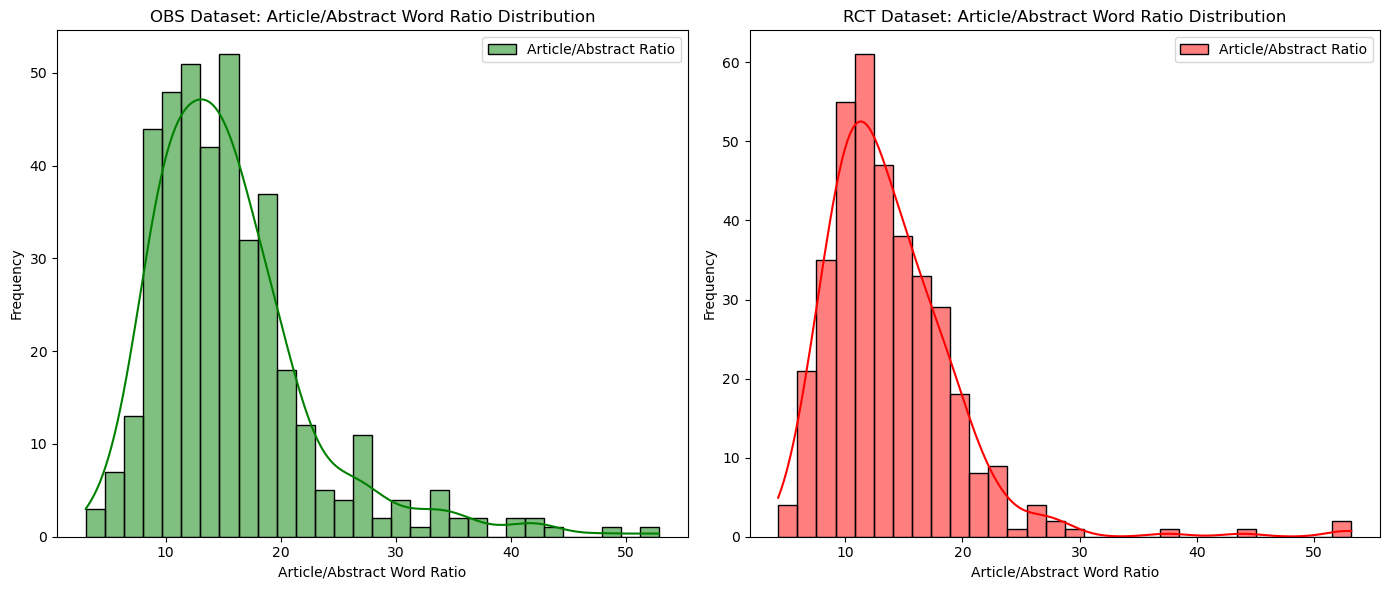

In [11]:
# Calculate the word ratio (article_length / abstract_length)
data_obs['word_ratio'] = data_obs['article_length'] / data_obs['abstract_length']
data_rct['word_ratio'] = data_rct['article_length'] / data_rct['abstract_length']

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# Plot for OBS dataset
sns.histplot(data_obs['word_ratio'], kde=True, color='green', label='Article/Abstract Ratio', bins=30, ax=axes[0])
axes[0].legend()
axes[0].set_title("OBS Dataset: Article/Abstract Word Ratio Distribution")
axes[0].set_xlabel("Article/Abstract Word Ratio")
axes[0].set_ylabel("Frequency")

# Plot for RCT dataset
sns.histplot(data_rct['word_ratio'], kde=True, color='red', label='Article/Abstract Ratio', bins=30, ax=axes[1])
axes[1].legend()
axes[1].set_title("RCT Dataset: Article/Abstract Word Ratio Distribution")
axes[1].set_xlabel("Article/Abstract Word Ratio")
axes[1].set_ylabel("Frequency")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
